In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def imshow(img, ax=None, vmin=None, vmax=None, figsize=(7, 7), external=False, title=""):
    if external:
        cv.imshow("imshow", img)
        
        while 1:
            if cv.waitKey(0) & 0xFF == ord("q"):
                break
        
        cv.destroyAllWindows()
        return
    
    gray = False

    if len(img.shape) == 2:
        gray = True
    if img.shape == 3 and img.shape[-1] == 1:
        gray = True

    # trying to remove as much as possible
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(title)
    ax.autoscale(tight=True)
    
    if gray:
        ax.imshow(img, cmap="gray", vmin=vmin, vmax=vmax)
    else:
        ax.imshow(img[:, :, ::-1], vmin=vmin, vmax=vmax)

## Color Correction

### Contrast Limited Adaptive Histogram Equalization (CLAHE)

In [3]:
def clahe(img, grid_size=7):
	clh_obj = cv.createCLAHE(clipLimit=2.0, tileGridSize=(grid_size, grid_size))
	lab_space = cv.cvtColor(img, cv.COLOR_BGR2LAB)
	img_channels = cv.split(lab_space)
	img_channels[0] = clh_obj.apply(img_channels[0])
	return cv.cvtColor(cv.merge(img_channels), cv.COLOR_LAB2BGR)

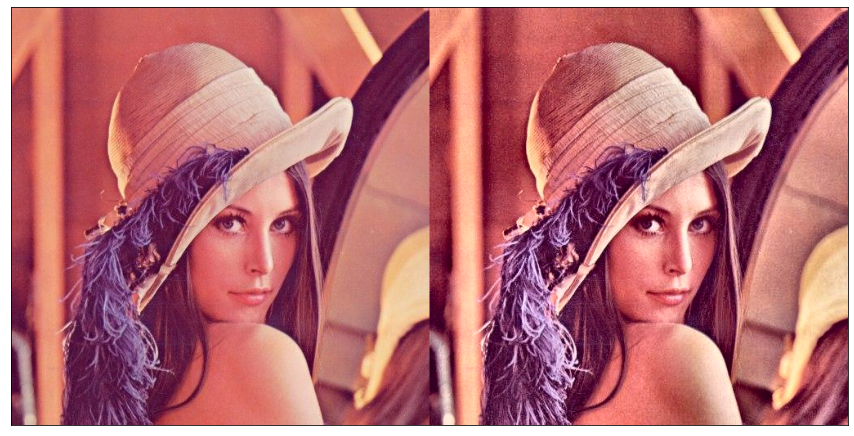

In [4]:
lena = cv.imread("images/lena.jpg")
imshow(np.hstack([lena, clahe(lena)]), figsize=(15, 15))